# Deep Unfolding
In this notebook we will compare the iterative soft thresholding algorithm (ISTA) to its deep unfolded version, coined learned ISTA (LISTA). LISTA is in fact the origin of deep unfolding methodology, proposed by Gregor and LeCun back in 2010, and has spurred a multitude of variants over the years. This notebook compares a basic implementation of it to the model-based ISTA, examining the ability of deep unfolding to increase the convergence rate of iterative optimizers. 


In [1]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import torch.nn as nn
from scipy.linalg import eigvalsh 
import numpy as np

import matplotlib.pyplot as plt

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float64)

## ISTA
We begin by recalling the formulation of ISTA. The original algorihtm aims at solving the LASSO problem
\begin{equation} 
	    \hat{\boldsymbol{s}} = \mathop{\arg\min}\limits_{\boldsymbol{s}} \frac{1}{2}\|\boldsymbol{x}-\boldsymbol{H}\boldsymbol{s}\|^2 +\rho\|\boldsymbol{s}\|_1,
\end{equation}
via the iterative update equations
\begin{equation}
         \boldsymbol{s}^{(k+1)} \leftarrow  \mathcal{T}_{\beta=\mu\rho}\left( \boldsymbol{s}^{(k)} - \mu \boldsymbol{H}^T(\boldsymbol{H}\boldsymbol{s}^{(k)}-\boldsymbol{x}) \right),    
\end{equation}
with $\mathcal{T}$ being the soft-thresholding operation.

Since one can probe convergence of ISTA when the step-size $\mu$ satisfies $\mu \leq \frac{1}{\max {\rm eig}(\boldsymbol{H}^T\boldsymbol{H})}$, we will use this value as our default setting of $\mu = 1/L$ with $L=\max {\rm eig}(\boldsymbol{H}^T\boldsymbol{H})$.

In [2]:
def ista(x, H, b_s, rho=0.5, L=1, max_itr=300):
    loss_vs_iter = np.zeros(max_itr)
    s_hat = torch.zeros(H.shape[1])
    proj = torch.nn.Softshrink(lambd=rho / L)
    for idx in range(max_itr):
        s_tild = s_hat - 1 / L * (H.T @ (H @ s_hat - x))
        s_hat = proj(s_tild)
        # Aggregate each iteration's MSE loss
        loss_vs_iter[idx] = F.mse_loss(s_hat, b_s, reduction="sum").data.item()

    return loss_vs_iter

## Data
Next, we generate a data set $\mathcal{D}=\{(\boldsymbol{s}_t, \boldsymbol{x}_t)\}_{t=1}^{n_t}$, where each $\boldsymbol{s}_t$ has $m=200$ entries, out of which at most $k=4$ are non-zero, while $\boldsymbol{x}_t$ has $n=150$ entires and is obtained via 
\begin{equation}
\boldsymbol{x}_t = \boldsymbol{H}\boldsymbol{s}_t + \boldsymbol{w}_t,
\end{equation}
with $\boldsymbol{w}_t$ being i.i.d. Gaussian noise.

To that aim, we generate a dedicated class inheriting Dataset to get the data samples, and to allow each tuple to be comprised of both $(\boldsymbol{s}_t, \boldsymbol{x}_t)$ as well as $\boldsymbol{H}$.

In [3]:
class SimulatedData(Data.Dataset):
    def __init__(self, x, H, s):
        self.x = x
        self.s = s
        self.H = H

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x = self.x[idx, :]
        H = self.H
        s = self.s[idx, :]
        return x, H, s

The next function creates a dataset.

In [4]:

def create_data_set(H, n, m, k, N=1000, batch_size=512, noise_dev=0.5):
    # Initialization
    x = torch.zeros(N, n)
    s = torch.zeros(N, m)

    # Create signals
    for i in range(N):
        # Create a k-sparsed signal s
        index_k = np.random.choice(m, k, replace=False)
        peaks = noise_dev * np.random.randn(k)

        s[i, index_k] = torch.from_numpy(peaks).to(s)

        # X = Hs+w
        #TODO NIR - does the noise_dev should be the same as this 0.01?
        x[i, :] = H @ s[i, :] + 0.01 * torch.randn(n) 

    simulated = SimulatedData(x=x, H=H, s=s)
    data_loader = Data.DataLoader(dataset=simulated, batch_size=batch_size, shuffle=True)
    return data_loader

Finally, we generate the data set

In [5]:
N = 1000 # number of samples
n = 150 # dim(x)
m = 200 # dim(s)
k = 4 # k-sparse signal

# Measurement matrix
H = torch.randn(n, m)
H /= torch.norm(H, dim=0)

# Generate datasets
train_loader = create_data_set(H, n=n, m=m, k=k, N=N)
test_loader = create_data_set(H, n=n, m=m, k=k, N=N, batch_size=N)

Let's see what the samples look like

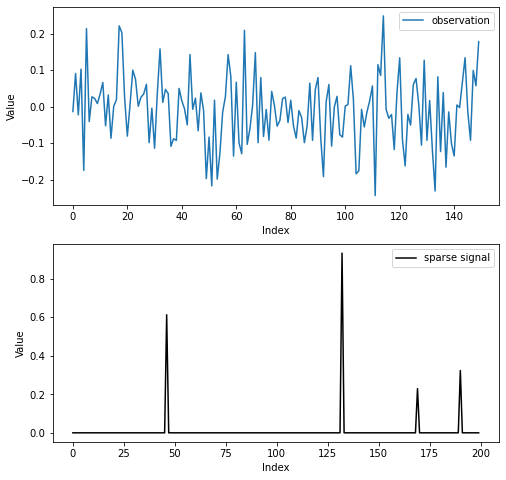

In [6]:
x_exm, _, s_exm =test_loader.dataset.__getitem__(5)
plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(x_exm, label = 'observation' ) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s_exm, label = 'sparse signal', color='k')  
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.show()

## Train and Validation

For training, we use SGDM with learning rate scheduler and the $\ell_2$ loss

In [7]:
def train(model, train_loader, valid_loader, num_epochs=50):
    """Train a network.
    Returns:
        loss_test {numpy} -- loss function values on test set
    """
    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-05,
        momentum=0.9,
        weight_decay=0,
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=50, gamma=0.1
    )
    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))
    # Main loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for step, (b_x, b_H, b_s) in enumerate(train_loader):
            s_hat, _ = model.forward(b_x)
            loss = F.mse_loss(s_hat, b_s, reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.zero_grad()
            train_loss += loss.data.item()
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # validation
        model.eval()
        test_loss = 0
        for step, (b_x, b_H, b_s) in enumerate(valid_loader):
            # b_x, b_H, b_x = b_x.cuda(), b_H.cuda(), b_s.cuda()
            s_hat, _ = model.forward(b_x)
            test_loss += F.mse_loss(s_hat, b_s, reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)
        # Print
        if epoch % 10 == 0:
            print(
                "Epoch %d, Train loss %.8f, Validation loss %.8f"
                % (epoch, loss_train[epoch], loss_test[epoch])
            )

    return loss_test

## Learned ISTA (LISTA)
As noted earlier, there are many variants of unfolded ISTA. Here we should use the following update equation:
\begin{equation}
         \boldsymbol{s}^{(k+1)} \leftarrow  \mathcal{T}_{\beta^{(k)}}\left( \boldsymbol{s}^{(k)} - \mu^{(k)} (\boldsymbol{B}\boldsymbol{s}^{(k)}+\boldsymbol{A}\boldsymbol{x}) \right),    
\end{equation}
with $\boldsymbol{A}, \boldsymbol{B}$ and $\{\beta^{(k)},\mu^{(k)}\}$ beging trainable parameters.

In [8]:
class LISTA_Model(nn.Module):
    def __init__(self, n, m, T=6, rho=1.0, H=None):
        super(LISTA_Model, self).__init__()
        self.n, self.m = n, m
        self.H = H
        self.T = T  # ISTA Iterations
        self.rho = rho  # Lagrangian Multiplier
        self.A = nn.Linear(n, m, bias=False)  # Weight Matrix
        self.B = nn.Linear(m, m, bias=False)  # Weight Matrix
        # ISTA Stepsizes eta
        self.beta = nn.Parameter(torch.ones(T + 1, 1, 1), requires_grad=True)
        self.mu = nn.Parameter(torch.ones(T + 1, 1, 1), requires_grad=True)
        # Initialization
        if H is not None:
            self.A.weight.data = H.t()
            self.B.weight.data = H.t() @ H

    def _shrink(self, s, beta):
        return beta * F.softshrink(s / beta, lambd=self.rho)

    def forward(self, x, s_gt=None):
        mse_vs_itr = []

        s_hat = self._shrink(self.mu[0, :, :] * self.A(x), self.beta[0, :, :])
        for i in range(1, self.T + 1):
            s_hat = self._shrink(s_hat - self.mu[i, :, :] * self.B(s_hat) + self.mu[i, :, :] * self.A(x),
                                 self.beta[i, :, :], )
            
            # Aggregate each iteration's MSE loss
            if s_gt is not None:
                mse_vs_itr.append(F.mse_loss(s_hat.detach(), s_gt.detach(), reduction="sum").data.item())

        return s_hat, mse_vs_itr

The following functions apply LISTA and ISTA for given data sets

In [9]:
def lista_apply(train_loader, test_loader, T, H):
    n = H.shape[1]
    m = H.shape[1]
    lista = LISTA_Model(n=n, m=m, T=T, H=H)
    train(lista, train_loader, test_loader)
    
    # Extract all samples and calculate MSE for each iteration
    s_gt, x = test_loader.dataset.s, test_loader.dataset.x
    _, mse_vs_iter = lista(x, s_gt=s_gt)

    return np.array(mse_vs_iter)/len(test_loader.dataset)

In [10]:
def ista_apply(test_loader, T, H, rho=0.5):
    H = H.cpu()
    m = H.shape[1]
    L = float(eigvalsh(H.t() @ H, eigvals=(m - 1, m - 1)))

    # Aggregate T iterations' MSE loss
    losses = np.zeros((len(test_loader.dataset), T))
    for idx, (x, _, b_s) in enumerate(test_loader.dataset):
        losses[idx, :] = ista(x=x, H=H, b_s=b_s, rho=rho, L=L, max_itr=T)

    return losses.mean(axis=0)

## Comparing LISTA to ISTA
Finally, we show that by learning the parameterization of ISTA in a per-iteration manner, one can notably improve its convergence rate. To that aim, in the following loop we compare ISTA to trained LISTA with different number of iterations.


Epoch 0, Train loss 0.90430683, Validation loss 0.86949169
Epoch 10, Train loss 0.20487403, Validation loss 0.15305775
Epoch 20, Train loss 0.03464069, Validation loss 0.03086743
Epoch 30, Train loss 0.01496401, Validation loss 0.01495947
Epoch 40, Train loss 0.00707210, Validation loss 0.00855395


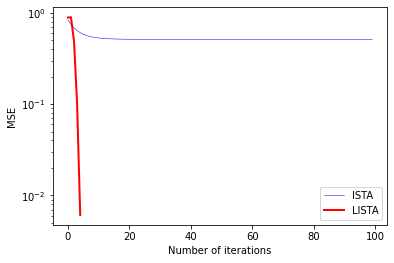

In [11]:

# number of unfolding
T_LISTA = 5
T_ISTA = 20*T_LISTA

# Train and apply LISTA with T iterations / layers
lista_mse_vs_iter = lista_apply(train_loader, test_loader, T_LISTA, H)

ista_mse_vs_iter = ista_apply(test_loader, T_ISTA, H)

# plot the resutls
fig = plt.figure()
plt.plot(range(T_ISTA), ista_mse_vs_iter, label='ISTA', color='b', linewidth=0.5)
plt.plot(range(T_LISTA), lista_mse_vs_iter, label='LISTA', color='r', linewidth=2)
plt.xlabel('Number of iterations', fontsize=10)
plt.ylabel('MSE', fontsize=10)
plt.yscale("log")
plt.legend()
plt.show()
